### plot params freq

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style("whitegrid")

In [20]:
import scipy

def plot_bins_gensj(df,sj_idx=None,cut_num=10,model=None):
    """bin average then correlate"""
    fig, ax = plt.subplots(figsize=(3,4))
    all_sj = np.unique(df['subject'])
    if sj_idx is not None:
        sj_ls = all_sj[sj_idx]
    else:
        sj_ls = all_sj
    n_sj = len(sj_ls)
    r_sj = np.empty((n_sj,))
    model_sj = np.empty((n_sj, cut_num))
    rate_sj = np.empty((n_sj, cut_num))
    model_rec = []
    bin_rec = []
    corr_num = 0
#     for idx, sj in enumerate(np.unique(df['subject'])):
    for idx, sj in enumerate(sj_ls):
        df_sj = df[df['subject']==sj]
        # p2 = ph
#         df_tmp = df_sj.dropna(subset=['p2'])
#         model_rank = df_tmp['gen_p2'].rank(method='max')
#         model_cut = df_tmp.groupby(pd.qcut(model_rank, cut_num))['gen_p2'].mean().values
#         rate_cut = df_tmp.groupby(pd.qcut(model_rank, cut_num))['p2'].mean().values
        # p1 = pl
#         df_tmp = df_sj.dropna(subset=['p1'])
#         model_rank = df_tmp['gen_p1'].rank(method='max')
#         model_cut = df_tmp.groupby(pd.qcut(model_rank, cut_num))['gen_p1'].mean().values
#         rate_cut = df_tmp.groupby(pd.qcut(model_rank, cut_num))['p1'].mean().values
        # both p
        df_tmp = df_sj.dropna(subset=['p'])
        model_rank = df_tmp['gen'].rank(method='max')
        model_cut = df_tmp.groupby(pd.qcut(model_rank, cut_num))['gen'].mean().values
        rate_cut = df_tmp.groupby(pd.qcut(model_rank, cut_num))['p'].mean().values

        nas = np.logical_and(np.isnan(model_cut), np.isnan(rate_cut)) # get rid of nans
        # no demean
        pr, pv = scipy.stats.pearsonr(model_cut[~nas], rate_cut[~nas])
#         print(f'subject %d, pearsonr %.3f, pval %.3f' %(sj, pr, pv))
        if rate_cut[1]-rate_cut[0]>0:
            color = '#0277BD'
            corr_num += 1
        else:
            color = '#B71C1C'
        sns.lineplot(x=[0.3,0.7], y=rate_cut, color=color, alpha=0.6)
        r_sj[idx] = pr
        model_sj[idx,:] = model_cut
        rate_sj[idx,:] = rate_cut

    dff = pd.DataFrame(rate_sj, columns=['L','H'])
    sns.boxplot(data=dff, width=0.5)
#     sns.violinplot(data=dff)
    sns.stripplot(data=dff, color='.3')

#     plt.xlabel('generative probability p(H)')
#     plt.ylabel('subject rated probability p(H)')
#     plt.xlabel('generative probability p(L)')
#     plt.ylabel('subject rated probability p(L)')
    plt.xlabel('generative probability p(congruent)')
    plt.ylabel('subject rated probability p(congruent)')
#     t0, p0 = scipy.stats.ttest_rel(r_sj,np.zeros((n_sj,)))
    print(dff.agg({'mean','std'}))
    t0, p0 = scipy.stats.ttest_rel(dff['L'], dff['H'])
    print(np.mean(r_sj), t0, p0, corr_num, corr_num/dff.shape[0])
#     plt.title(f'Pearson r={np.mean(r_sj):.3f} (t({len(r_sj)})={t0:.3f}, p={p0:.3e})')
#     plt.title(f't({dff.shape[0]})={t0:.2f}***')
    if model is not None:
        fig_name = f'bins_{model:s}.pdf'
        fig_path = os.path.join('figs',fig_name)
        plt.savefig(fig_path, bbox_inches='tight')

def demean(df):
    """demean"""
    df_dm = (df-np.mean(df))/np.std(df)
    return df_dm

In [4]:
df_pmod = pd.read_csv('./local_output_mean/fmri_io_jump_freq.csv')
df_gen = pd.read_csv('../data/fmri_behavioural_new.csv')
df_genmod = pd.concat([df_gen, df_pmod], axis=1)
df_gm = df_genmod.loc[:,~df_genmod.columns.duplicated()]
df_gm.shape

(44200, 24)

In [7]:
df_gm['gen_p1g1'] = 1 - df_gm['gen_p2g1']
df_gm['gen_p2g2'] = 1 - df_gm['gen_p1g2']
df_gm['gen_p1'] = (df_gm['gen_p1g1'] + df_gm['gen_p1g2'])/(df_gm['gen_p1g1'] + df_gm['gen_p1g2']+df_gm['gen_p2g1'] + df_gm['gen_p2g2'])
df_gm['gen_p2'] = (df_gm['gen_p2g1'] + df_gm['gen_p2g2'])/(df_gm['gen_p1g1'] + df_gm['gen_p1g2']+df_gm['gen_p2g1'] + df_gm['gen_p2g2'])

<ipython-input-7-3a1e52a318b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gm['gen_p1g1'] = 1 - df_gm['gen_p2g1']
<ipython-input-7-3a1e52a318b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gm['gen_p2g2'] = 1 - df_gm['gen_p1g2']


In [8]:
df_gm.head()

,subject,session,trial,seq,rt,gen_p1g2,gen_p2g1,prob_pxl,prob_obs,obs_p1g2,...,p2,pmod_mean,pmod_mean_p2,pmod_surprise,pmod_sd,pmod_pe,gen_p1g1,gen_p2g2,gen_p1,gen_p2
0,6,1,1,2,NaN,0.2,0.65,NaN,NaN,NaN,...,NaN,0.394060,0.605940,1.000000,0.283625,0.219330,0.35,0.8,0.275,0.725
1,6,1,2,2,NaN,0.2,0.65,NaN,NaN,NaN,...,NaN,0.362067,0.637933,0.722753,0.282842,0.028271,0.35,0.8,0.275,0.725
2,6,1,3,2,NaN,0.2,0.65,NaN,NaN,NaN,...,NaN,0.347829,0.652171,0.648523,0.284506,0.006845,0.35,0.8,0.275,0.725
3,6,1,4,2,NaN,0.2,0.65,NaN,NaN,NaN,...,NaN,0.340348,0.659652,0.616678,0.286210,0.002342,0.35,0.8,0.275,0.725
4,6,1,5,2,NaN,0.2,0.65,NaN,NaN,NaN,...,NaN,0.335986,0.664014,0.600222,0.287567,0.000981,0.35,0.8,0.275,0.725


             L         H
mean  0.470835  0.534374
std   0.063169  0.041844
0.42857142857142855 -4.437887826725164 9.0826387569464e-05 25 0.7142857142857143


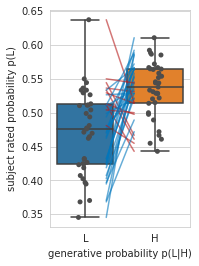

In [5]:
plot_bins_gensj(df_gm, sj_idx=None, cut_num=2)
# plt.savefig('./figs/genobs_2bins_fmri.png', bbox_inches='tight')
# plt.savefig('./figs/genobs_2bins_fmri_p2.png', bbox_inches='tight')

             L         H
mean  0.459808  0.544135
std   0.062800  0.048296
0.6571428571428571 -5.500011715216782 3.84753062238227e-06 29 0.8285714285714286


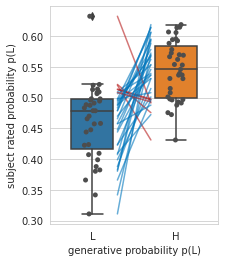

In [17]:
plot_bins_gensj(df_gm, sj_idx=None, cut_num=2)
# plt.savefig('./figs/genobs_2bins_fmri.png', bbox_inches='tight')
plt.savefig('./figs/genobs_2bins_fmri_p2only.png', bbox_inches='tight')

             L         H
mean  0.466406  0.544070
std   0.043675  0.069675
0.6571428571428571 -5.1096766408143734 1.2380124712166218e-05 29 0.8285714285714286


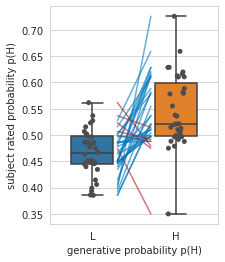

In [19]:
plot_bins_gensj(df_gm, sj_idx=None, cut_num=2)
plt.savefig('./figs/genobs_2bins_fmri_p1only.png', bbox_inches='tight')

In [21]:
df_l = df_gm[['subject', 'gen_p1', 'p1']]
df_h = df_gm[['subject', 'gen_p2', 'p2']]
df_l.rename(columns={'gen_p1':'gen', 'p1':'p'}, inplace=True)
df_h.rename(columns={'gen_p2':'gen', 'p2':'p'}, inplace=True)
df_hl = pd.concat([df_l, df_h])

/home/fs0/syzhang/.conda/envs/np_env/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


             L         H
mean  0.460045  0.543755
std   0.038750  0.040460
0.7142857142857143 -6.2662047796509714 3.8941088423030293e-07 30 0.8571428571428571


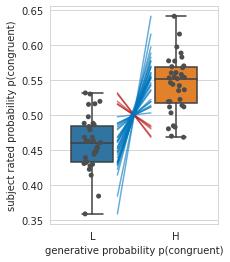

In [22]:
plot_bins_gensj(df_hl, sj_idx=None, cut_num=2)
plt.savefig('./figs/genobs_2bins_fmri_ponly.png', bbox_inches='tight')